In [ ]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 11.83 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab/Mecab-ko-for-Google-Colab/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-10-18 03:51:18--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 18.205.93.1, 18.205.93.2, 18.205.93.0, ...
Connecting to bitbucket.org (bitbucket.org)|18.205.93.1|:443... connected.
HTTP request sent, awaiting response... 302 Found

In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 1) 데이터 로드하기

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7f57c197b310>)

In [ ]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 수:',len(total_data))

total_data

전체 리뷰 수: 200000


,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ
...,...,...
199995,2,장마라그런가!!! 달지않아요
199996,5,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...
199997,5,로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요
199998,5,넘이쁘고 쎄련되보이네요~


## 2)훈련데이터와 테스트 데이터 분리하기 
현재의 데이터셋에는 레이블이 딱히 없어서 추가를 해줘야 함.
rating이 4이상은 레이블 1, rating이 2 이하는 0을 부여


In [ ]:
# y_data로 쓸 레이블 추가 np.select(['조건'],[바꿀 숫자], default:나머지 = 0)
total_data['label'] = np.select([total_data.ratings >3],[1],default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [ ]:
# 중복제외 샘플의 수 카운트 #새로 추가한 열 DataFrame화 시키기
total_data['label']=pd.DataFrame(total_data['label'])
total_data['ratings'].nunique() , total_data['reviews'].nunique(),total_data['label'].nunique()

(4, 199908, 2)

In [ ]:
#중복제거
total_data.drop_duplicates(subset=['reviews'], inplace=True)

In [ ]:
# NULL 값 유무 확인
total_data.isnull().values.any()

False

In [ ]:
#훈련데이터와 테스트 데이터 3:1 비율로 분리하기 
train_data, test_data = train_test_split(total_data, test_size=0.25, random_state =42) #random_state = None이면 처음 결과를 추출하고 다음 결과를 추출할 때 기록이 초기화 되므로, 상황마다 값이 달라진다. random_state의 숫자는 딱히 상관 없음
print('훈련용 리뷰 개수:', len(train_data))
print('테스트 리뷰 개수:', len(test_data))

훈련용 리뷰 개수: 149931
테스트 리뷰 개수: 49977


## 3) 레이블 분포 확인

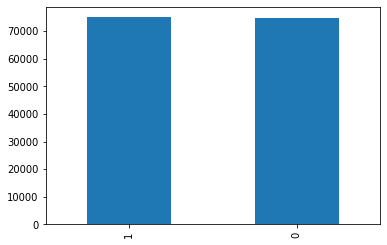

In [ ]:
train_data['label'].value_counts().plot(kind='bar')

In [ ]:
# 레이블의 분포현황
train_data['label'].value_counts()

1    75013
0    74918
Name: label, dtype: int64

## 4) 데이터 정제하기

In [ ]:
# 한글과 공백을 제외하고 모두 제거 및 확인하기
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace("", np.nan, inplace= True)
print(train_data.isnull().sum())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


ratings    0
reviews    0
label      0
dtype: int64


In [ ]:
# 테스트 데이터도 마찬가지로 정제화 
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['reviews'].replace("", np.nan, inplace= True)
print(test_data.isnull().sum())

ratings    0
reviews    0
label      0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


## 5) 토큰화 진행하기

In [ ]:
mecab = Mecab()
print(mecab.morphs('정말 거지같은게 왜 이렇게 나대고 지랄이냐?'))

['정말', '거지', '같', '은', '게', '왜', '이렇게', '나대', '고', '지랄', '이', '냐', '?']


In [ ]:
#불용어 지정, 필요없는 토큰 제거
stopwords=['게','은','는','이','가','이','냐','고']

In [ ]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

## 6) 단어와 길이 분포 확인하기
긍정 리뷰에는 주로 어떤 단어들이 등장하고, 부정 리뷰에는 주로 어떤 단어들이 등장하는지 두 가지 경우에 대해 각 단어의 빈도수 계산해본다. \
각 레이블에 따라서 단어들의 리스트를 저장해주기

In [ ]:
negative_word = np.hstack(train_data[train_data.label == 0]['tokenized'].values) #np.hstack 배열을 수평방향으로 쌓기 
positive_word = np.hstack(train_data[train_data.label == 1]['tokenized'].values)
print(negative_word)
print(positive_word)

['사이즈' '를' '센치' ... '장' '가능' '해요']
['적당' '하' '만족' ... '잘' '삿' '어요']


In [ ]:
negative_word_count = Counter(negative_word)
print(negative_word_count.most_common(20))

[('네요', 31799), ('하', 29950), ('에', 23553), ('도', 23038), ('는데', 20295), ('안', 19718), ('어요', 14849), ('있', 13200), ('너무', 13058), ('했', 11783), ('지', 11511), ('을', 10894), ('한', 10580), ('좋', 9812), ('배송', 9677), ('다', 9506), ('같', 8997), ('구매', 8876), ('어', 8869), ('거', 8854)]


In [ ]:
positive_word_count = Counter(positive_word)
print(positive_word_count.most_common(20))

[('좋', 39488), ('하', 31758), ('도', 28086), ('아요', 21184), ('에', 20136), ('네요', 19895), ('어요', 18686), ('잘', 18602), ('구매', 16171), ('습니다', 13320), ('있', 12391), ('배송', 12275), ('는데', 11670), ('했', 9818), ('합니다', 9801), ('먹', 9635), ('재', 9273), ('너무', 8397), ('같', 7868), ('한', 7420)]


긍정 리뷰의 평균 길이: 15.16937064242198
부정 리뷰의 평균길이: 18.908686830935157


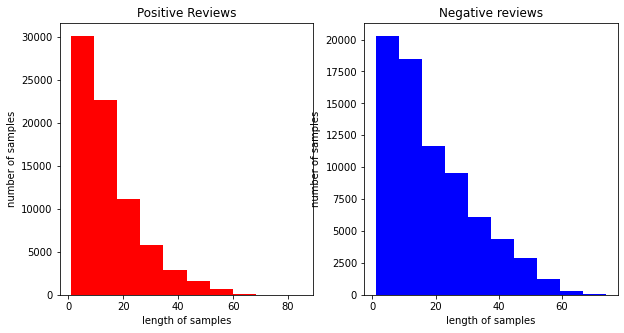

In [ ]:
fig,(ax1, ax2) = plt.subplots(1,2,figsize=(10,5)) # 그래프 두 개를 한 figure 내에 그리기 , subplot(row,column,index)
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x)) # df[df['column'] == 0]['tokenized'] df의 특정 열의 조건을 추출하는 함수에서 column이 'tokenized'인 것 / map(lambda x: len(x)) : 문자열 길이 
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이:', np.mean(text_len) )

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color = 'blue')
ax2.set_title('Negative reviews')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균길이:', np.mean(text_len))

plt.show()


In [ ]:
X_train = train_data['tokenized'].values #데이터프레임의 행들의 값 Series 형태
y_train = train_data['label'].values
X_test = test_data['tokenized'].values
y_test = test_data['label'].values

## 7) 정수 인코딩

기계가 텍스트를 숫자로 처리할 수 있도록 훈련데이터와 테스트 데이터에 정수 인코딩을 수행해야 한다.

- tokenizer =Tokenizer(num_words=100) : 단어 빈도 수가 높은 순으로 100개만 사용 나머지는 고려x
- tokenizer.fit_on_texts(sentences) : fit_on_texts() 메서드는 문자 데이터를 입력받아서 리스트 형태로 변환
- sequences=tokenizer.texts_to_sequences(sentences) : texts_to_sequences(sentences)메서드는 텍스트 안의 단어들을 숫자의 시퀀스 형태롤 변환
- padded = pad_sequences(sequences): 숫자 0을 이용해서 최장거리의 시퀀스(문장) 길이 만큼 똑같은 길이 시퀀스로 변환

In [ ]:
tokenizer= Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
# 등장횟수 1회인 단어들은 자연어 처리에서 배제
threshold =2
total_cnt = len(tokenizer.word_index) #tokenizer.word_index : 빈도수가 가장 높은 것부터 순위대로 나열 / total_cnt: 전체데이터 빈도수 총 합
rare_cnt = 0 # 등장 빈도 수가 threshold보다 작은 단어의 갯수 카운트
total_freq =0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq= 0 # 등장 빈도 수가 threshold보다 작은 단어의 등장 빈도 수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items(): #tokenizer.word_counts.items() : 각 단어의 빈도 수(개 수)
    total_freq=total_freq + value

    #단어의 등장 빈도 수가 threshold보다 작으면
    if value < threshold:
      rare_cnt = rare_cnt +1
      rare_freq = rare_freq + value

print('단어 집합의 크기', total_cnt)
print('등장빈도가 %s번 이하인 희귀 단어의 수: %s' %(threshold -1, rare_cnt))
print('단어 집합에서 희귀 단어의 비율:', (rare_cnt/total_cnt)*100)
print('전체 등장 빈도(훈련데이터)에서 희귀 단어 등장 빈도 비율:', (rare_freq/total_freq)*100)



단어 집합의 크기 40013
등장빈도가 1번 이하인 희귀 단어의 수: 18213
단어 집합에서 희귀 단어의 비율: 45.51770674530778
전체 등장 빈도(훈련데이터)에서 희귀 단어 등장 빈도 비율: 0.7129768201304285


### tokenizer.word_index 와  tokenizer.word_counts.items()의 차이점은?
- 둘의 단어의 크기는 같다.
- tokenizer.word_index는  각 단어의 형태소를 빈도 수 별로 순위를 나타낸 것이다.
- tokenizer.word_counts.items() 은 각 단어 형태소(item)의 크기를 나타낸 것이다.

In [ ]:
# 빈도 수가 1회인 단어들의 비중이 0.8% 밖에 되지 않으므로 정수 인코딩 과정에서 배제시킨다.
vocab_size=total_cnt-rare_cnt 
print('단어 집합 크기:', vocab_size)

단어 집합 크기: 21800


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:3])

[[76, 71, 2075, 314, 14274, 278, 4, 83, 9, 250, 181, 150, 821, 2966, 18, 641, 3, 87, 70, 221, 48, 1359, 168, 5, 9], [498, 425, 60, 8545, 2576, 2532, 355, 6, 2933, 265, 2372, 46, 489, 3], [54, 31, 841, 115, 43, 6, 2387, 173, 10, 13, 8076, 7, 1335, 36, 153, 337, 49, 67, 173, 153, 10, 1931, 3, 123, 175, 26, 1395, 339, 130, 2, 149, 26]]


## 8) 패딩
서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업을 진행.

리뷰 최대 길이: 85
리뷰 평균 길이: 17.03784407494114


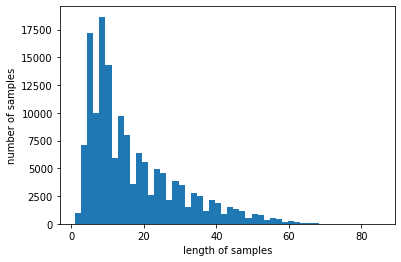

In [ ]:
print('리뷰 최대 길이:',max(len(review) for review in X_train))
print('리뷰 평균 길이:', sum(map(len, X_train)) / len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
len(X_train)

149931

In [ ]:
sum(map(len,X_train)) 

2554501

In [ ]:
def below_threshold_len(max_len, nested_list):
  count=0
  for sentence in nested_list:
    if len(sentence) <= max_len:
      count=count+1
  
  print('전체 샘플 중 길이가 {} 이하인 샘플의 비율: {}'.format(max_len, (count/len(nested_list))*100))

In [ ]:
max_len=70
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 70 이하인 샘플의 비율: 99.99132934483195


## 9) GRU로 네이버 쇼핑 리뷰 감성 분류하기

(1) 하이퍼파라미터
  - 임베딩 벡터차원: 100
  - 은닉 상태 크기: 128
  - 모델구조: 다 대 일 구조의 LSTM
  - 배치 크기: 64
  - 에포크:15

(2) 분류구조: 이진분류
  - 회귀 : 로지스틱 회귀
  - 활성화 함수: 시그모이드 함수
  - 손실함수: 크로스 엔트로피 함수

(3) EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
  - 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후
  - 검증 데이터 손실이 4회 증가(patience)하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping) 한다는 의미

(4) ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
  - 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장
  - monitor: 모델 저장할 때, 기준이 되는 값/ ex)'val_loss', 'loss', 'val_acc'
  - mode: 'auto', 'max', 'min'
  - verbose: 0은 그냥 암묵적 저장 / 1은 저장 표시
  - save_best_only: True인 경우, monitor 되고 있는 값을 기준으로 가장 좋은 값으로 모델이 저장 / False인 경우, 에폭마다 모델이 filepath[epoch]로 저장. 

cf) Call back 함수 정의
#### https://deep-deep-deep.tistory.com/m/53 

(5) 검증데이터는 기계가 훈련데이터에 과적합되고 있지는 않은지 확인하기 위한 용도로 사용
  

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model=Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))
es= EarlyStopping(monitor='val_loss', mode='min' , verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True) # 케라스는 HDF5(.h5) 표준 포맷을 제공해서, 모델의 가중치, 모델 구성, 옵티마이저 설정까지 저장함

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc']) #모델 컴파일 
history = model.fit(X_train, y_train, epochs= 10, callbacks=[es,mc], batch_size= 64, validation_split=0.2) #모델훈련

model.save('model1.h5') #인공지능 모델 저장


In [ ]:
loaded_model = load_model('best_model.h5') # 모델 복원하기
print("테스트 정확도:{}%".format(loaded_model.evaluate(X_test, y_test)[1])) 

In [ ]:
#모델 복원하기
import tensorflow as tf

loaded_model = tf.keras.models.load_model('model1.h5')
loaded_model.summary()

loss, acc = loaded_model.evaluate(X_test,y_test)
print()

## 10) 리뷰 예측해보기


In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣'],'',new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) #토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] #불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) #정수 인코딩
  pad_new = pad_sequence(encoded, maxlen = max_len) #패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if score>0.5:
    print("{}%확률로 긍정 리뷰입니다.".format(score*100))
  else:
    print("{}%확률로 부정 리뷰입니다.".format(score*100))